In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from Adam import Adam
from timeit import default_timer
import operator
from functools import reduce
from functools import partial
from normal import UnitGaussianNormalizer
from matplotlib import cm
import scipy.io
from utilities3 import LpLoss
from deeponet import DeepONet2D
from gru2 import GRUModel

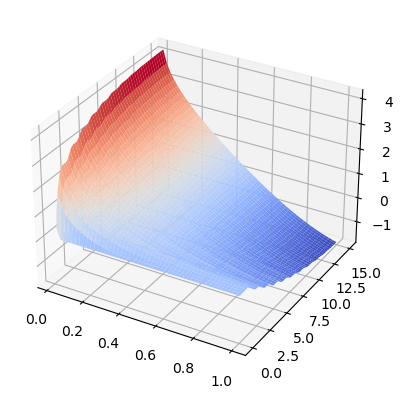

In [6]:
# Load Data

L = 1
T = 14.95
dt = 0.05
dx = 0.02
nt = int(round(T/dt))
nx = int(round(L/dx))
npoints = 1000

t1 = np.linspace(0.05, T, nt, dtype=np.float32)
x1 = np.linspace(0.02, L, nx)

x = scipy.io.loadmat("u.mat")["uData"]
x = x.reshape(npoints, nt, nx).astype(np.float32)
y = scipy.io.loadmat("thetaHat.mat")["tHatData"]
y = y.reshape(npoints, nt, nx).astype(np.float32)
    


x1, t1 = np.meshgrid(x1, t1)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x1, t1, y[0, :, :], cmap=cm.coolwarm)

In [7]:
# Define a sequential torch network for batch and trunk. Can use COV2D which we will show later
branch = nn.Sequential(
    GRUModel(200, 50, 10*nx))

trunk = nn.Sequential(
          nn.Linear(50, 512),
          nn.ReLU(),
          nn.Linear(512,10*nx),
          nn.ReLU()
)
print(branch)
print(trunk)

Sequential(
  (0): GRUModel(
    (gru): GRU(50, 200, batch_first=True)
    (fc): Linear(in_features=200, out_features=500, bias=True)
  )
)
Sequential(
  (0): Linear(in_features=50, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=500, bias=True)
  (3): ReLU()
)


In [8]:
# Parameters
epochs = 1000
ntrain = 900
ntest = 100
batch_size = 20
gamma = 0.5
learning_rate = 0.001
step_size= 100

In [9]:
# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()

grid_repeated = []
for i in range(batch_size):
    grid_repeated.append(t1)
grid_repeated = torch.from_numpy(np.array(grid_repeated)).cuda()
print(grid_repeated.shape)

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

torch.Size([20, 299, 50])


In [10]:
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, 
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c

In [11]:
model = DeepONet2D(branch, trunk, 50).cuda()
print(count_params(model))

534312


In [12]:
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [13]:
t = default_timer()
loss = LpLoss()
train_mseArr = []
test_mseArr = []
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(x, grid_repeated)
        mse = loss(out, y)
        mse.backward()
        
        optimizer.step()
        train_mse += mse.item()
        
    scheduler.step()
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for x, y in testData:
            x, y = x.cuda(), y.cuda()
            
            out = model(x, grid_repeated)
            test_mse += loss(out, y).item()
            
    train_mse /= len(trainData)
    test_mse /= len(testData)
    
    train_mseArr.append(train_mse)
    test_mseArr.append(test_mse)
    
    t2 = default_timer()
    if ep%50 == 0:
        print(ep, t2-t1, train_mse, test_mse)
print(default_timer()-t)


0 0.6377097270451486 0.7108259201049805 0.595558249950409
50 0.5521099637262523 0.05502580180764198 0.05402542054653168
100 0.5497906808741391 0.04123623652590646 0.041503147780895235
150 0.6022050129249692 0.033284573546714255 0.03388717845082283
200 0.43027600506320596 0.027990215106142892 0.027363542839884757
250 0.6155932019464672 0.024675817746255133 0.026448972150683404
300 0.5917253191582859 0.022190897829002805 0.023698604851961135
350 0.4348418661393225 0.020710309139556356 0.022043867409229277
400 0.4410521211102605 0.01915962640196085 0.02047940865159035
450 0.5290277251042426 0.018250629947417312 0.019519816897809506
500 0.43206865806132555 0.017308948044147756 0.018912516720592975
550 0.47696152003481984 0.01711009753247102 0.018669859692454337
600 0.4339035018347204 0.016493959373070133 0.018032795377075674
650 0.5472224168479443 0.016310230849517715 0.01799205653369427
700 0.4365371181629598 0.01607042182650831 0.017792910523712634
750 0.43423858331516385 0.0159347581987

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


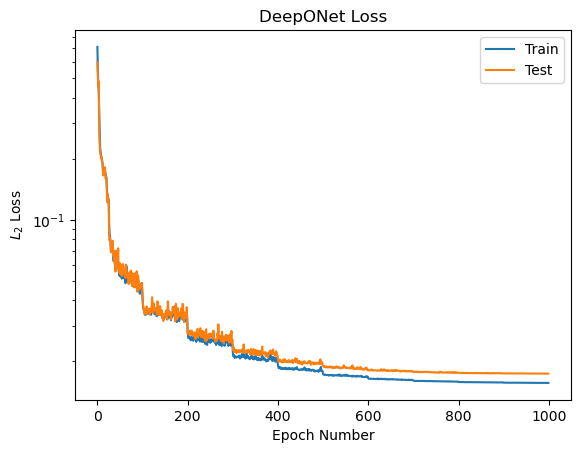

In [14]:
plt.plot(train_mseArr, label="Train")
plt.plot(test_mseArr, label="Test")
plt.yscale("log")
plt.title("DeepONet Loss")
plt.xlabel("Epoch Number")
plt.ylabel(r"$L_2$ Loss")
plt.legend()
plt.savefig("deeponet.eps")

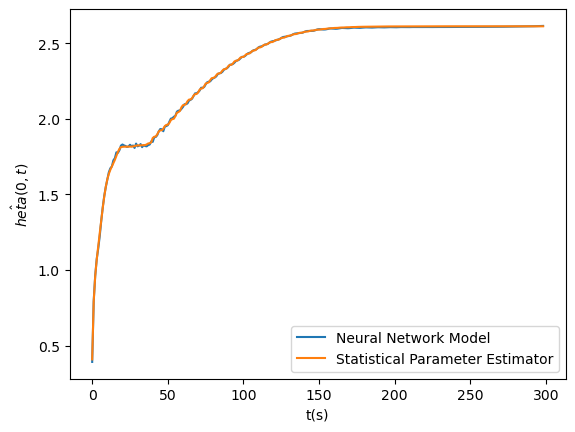

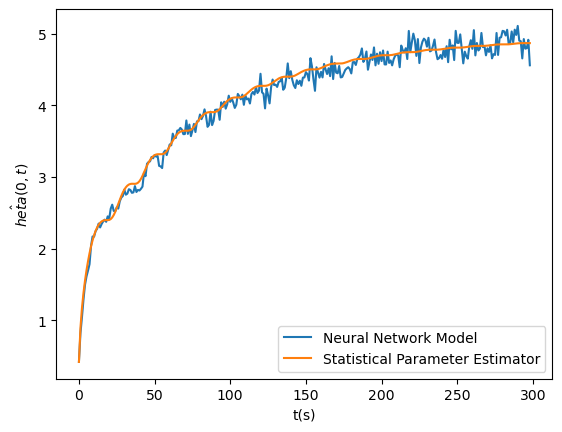

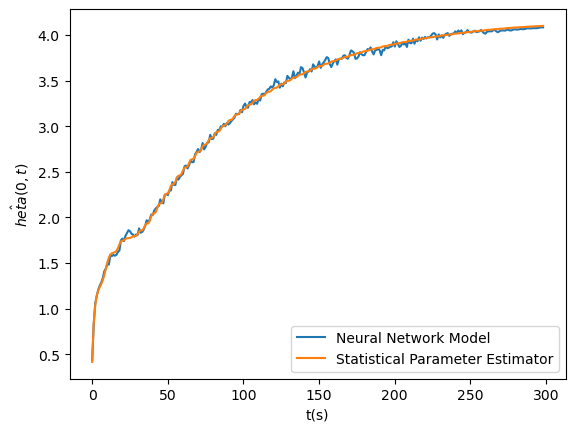

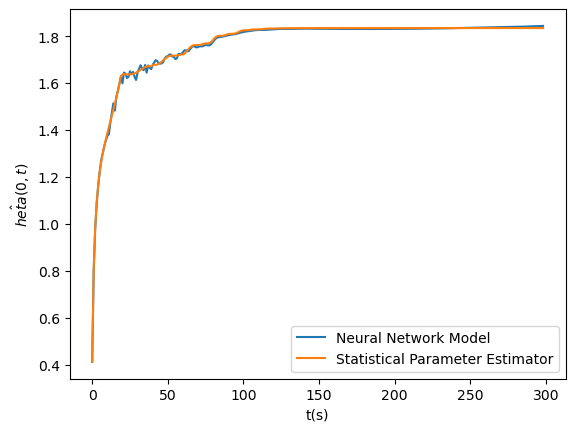

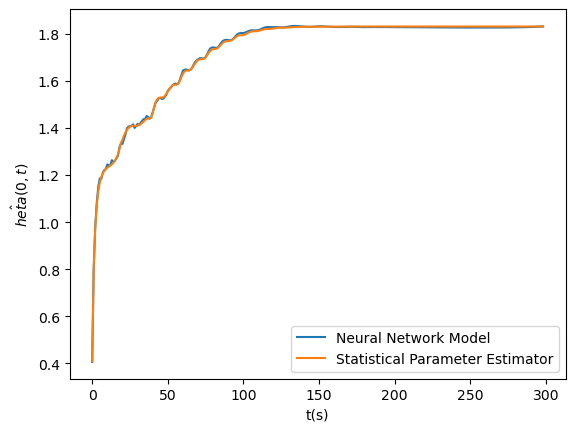

In [15]:
# Show some examples at the boundry
with torch.no_grad():
    for x, y in testData:
        x, y = x.cuda(), y.cuda()   
        out = model(x, grid_repeated)
        plt.figure()
        plt.plot(out[0,:, 0].detach().cpu(), label="Neural Network Model")
        plt.plot(y[0, :, 0].detach().cpu(), label="Statistical Parameter Estimator")
        plt.legend()
        plt.xlabel("t(s)")
        plt.ylabel("$\hat{\theta}(0, t)$")

In [16]:
torch.save(model.state_dict(), 'deeponet1')